In [ ]:
# DISCRETE COURIER TRANSFORM 
import numpy as np
import pandas as pd
from scipy.fft import idct
from scipy.fft import dct

# read the CSV file data
real_data = pd.read_csv('/content/rpmreading.csv', parse_dates=['timestamp'])

# extract the CSV file time series data
timeseries_data = real_data['value'].values

# apply Discrete Courier Transform function(inbuilt) to the extracted data
dct_data = dct(timeseries_data)

# set the last 90% of the coefficients as zero
dctdata_size = len(dct_data)
dctdata_zero = int(0.1 * dctdata_size)
dct_data[dctdata_zero:] = 0

# construct the time series data using the modified coefficients
new_timeseries_data = idct(dct_data)

# create a new DataFrame with the new time series data constructed
transformed_data = pd.DataFrame({'timestamp': real_data['timestamp'], 'nodeid': real_data['nodeid'], 'source': real_data['source'], 'fqdd': real_data['fqdd'], 'value': new_timeseries_data})

# change the newly constructed data to a new CSV file
transformed_data.to_csv('transformed_data.csv', index=False)


In [ ]:
import pandas as pd

# read the first CSV file
df1 = pd.read_csv('/content/rpmreading.csv')

# read the second CSV file
df2 = pd.read_csv('/content/transformed_data.csv')

# get the number of rows and columns in each dataframe
rows1, cols1 = df1.shape
rows2, cols2 = df2.shape

# calculate the total number of elements in each dataframe
elements1 = rows1 * cols1
elements2 = rows2 * cols2

# compare the total number of elements in each dataframe
if elements1 > elements2:
    print('File 1 has a larger data volume than File 2' + str(elements1) + " " + str(elements2))
elif elements1 < elements2:
    print('File 2 has a larger data volume than File 1')
else:
    print('File 1 and File 2 have the same data volume')

File 1 has a larger data volume than File 2859975 781575


# New Section

In [ ]:
#DOWNSAMPLING
import pandas as pd
import psutil
import time

# Get memory usage before compression
downsampling_before_memory = psutil.virtual_memory().used

# Record start time
downsampling_start_time = time.time()

# Record end time
downsampling_end_time = time.time()

# Start monitoring CPU usage
psutil.cpu_percent(interval=1)

# read the input real data
real_data = pd.read_csv('/content/rpmreading.csv')

# set the downsampling factor
downsample_factor = 2

# group the data by nodeid and fqdd
grouped_data = real_data.groupby(['nodeid', 'fqdd'])

# take the mean of every n rows
downsampled = grouped_data.apply(lambda x: x.reset_index(drop=True).iloc[::downsample_factor].reset_index(drop=True))

# save the downsampled data to a file
downsampled.to_csv('downsampled_data.csv', index=False)

cpu_usage = psutil.cpu_percent(interval=1, percpu=True)
downsampling_cpu_usage = sum(cpu_usage) / len(cpu_usage)

print("Downsampling CPU Usage : {:.2f}%".format(downsampling_cpu_usage))

# Get memory usage after compression
downsampling_after_memory = psutil.virtual_memory().used

# Calculate memory usage during compression
memory_used_during_downsampling = (downsampling_after_memory - downsampling_before_memory)/(1024*1024)
print('Downsampling Memory Usage in mega bytes : ', memory_used_during_downsampling)

# Calculate processing time
downsampling_processing_time = downsampling_end_time - downsampling_start_time
print("Downsampling Processing Time : {:.7f} seconds".format(downsampling_processing_time))

Downsampling CPU Usage : 3.50%
Downsampling Memory Usage in mega bytes :  21.57421875
Downsampling Processing Time : 0.0000224 seconds


In [ ]:
# RUN LENGTH ENCODING
import psutil
import time
import pandas as pd

# Get memory usage before compression
runlengthencoding_before_memory = psutil.virtual_memory().used

# Record start time
runlengthencoding_start_time = time.time()

# Record end time
runlengthencoding_end_time = time.time()

# Start monitoring CPU usage
psutil.cpu_percent(interval=1)

# Read the input data from CSV file
real_data = pd.read_csv('/content/rpmreading.csv')

# Perform run-length encoding on the 'value' column for each node and source
data_encoded = []
for nodeid in real_data['nodeid'].unique():
    for source in real_data['source'].unique():
        values = real_data[(real_data['nodeid'] == nodeid) & (real_data['source'] == source)]['value']
        values_encoded = []
        count = 1
        for i in range(1, len(values)):
            if values.iloc[i] == values.iloc[i-1]:
                count += 1
            else:
                values_encoded.append((values.iloc[i-1], count))
                count = 1
        values_encoded.append((values.iloc[-1], count))
        data_encoded.append({
            'nodeid': nodeid,
            'source': source,
            'encoded_values': values_encoded
        })

# Convert the encoded data into a DataFrame and save it to a CSV file
data_encoded = pd.DataFrame(data_encoded)
data_encoded.to_csv('runlengthencoded_data.csv', index=False)

cpu_usage = psutil.cpu_percent(interval=1, percpu=True)
runlengthencoding_cpu_usage = sum(cpu_usage) / len(cpu_usage)
print("Run Length Encoding CPU Usage: {:.2f}%".format(runlengthencoding_cpu_usage))

# Get memory usage after compression
runlengthencoding_after_memory = psutil.virtual_memory().used

# Calculate memory usage during compression
memory_used_during_runlengthencoding = (runlengthencoding_after_memory - runlengthencoding_before_memory)/(1024*1024)
print('Run Length Encoding Memory Usage in mega bytes : ', memory_used_during_runlengthencoding)

# Calculate processing time
runlengthencoding_processing_time = runlengthencoding_end_time - runlengthencoding_start_time
print("Run Length Encoding Processing Time: {:.7f} seconds".format(runlengthencoding_processing_time))


Run Length Encoding CPU Usage: 78.90%
Run Length Encoding Memory Usage in mega bytes :  39.45703125
Run Length Encoding Processing Time: 0.0000389 seconds


In [ ]:
# HUFFMAN ENCODING
import psutil
import time
import pandas as pd
from collections import defaultdict
import heapq

# Get memory usage before compression
huffmanencoding_before_memory = psutil.virtual_memory().used

# Start monitoring CPU usage
psutil.cpu_percent(interval=1)

# Record start time
huffmanencoding_start_time = time.time()

# Record end time
huffmanencoding_end_time = time.time()

# Read the input real data into a pandas dataframe
real_data = pd.read_csv('/content/rpmreading.csv')

# Get the frequency of occurrence of each value in the "value" column
value_counts = real_data['value'].value_counts()

# Build a Huffman tree from the frequency counts
heap = [[count, [value, ""]] for value, count in value_counts.items()]
heapq.heapify(heap)
while len(heap) > 1:
    lo = heapq.heappop(heap)
    hi = heapq.heappop(heap)
    for pair in lo[1:]:
        pair[1] = '0' + pair[1]
    for pair in hi[1:]:
        pair[1] = '1' + pair[1]
    heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

# Get the Huffman codes for each value in the "value" column
huffman_codes = dict(heapq.heappop(heap)[1:])

# Encode the "value" column using the Huffman codes
huffman_encoded_values = real_data['value'].apply(lambda x: huffman_codes[x])

# Convert the encoded data and save it to a CSV file
huffman_encoded_values.to_csv('huffmanencoded_data.csv', index=False)

cpu_usage = psutil.cpu_percent(interval=1, percpu=True)
huffmanncoding_cpu_usage = sum(cpu_usage) / len(cpu_usage)
print("Huffman Encoding CPU Usage: {:.2f}%".format(huffmanncoding_cpu_usage))

# Get memory usage after compression
huffmanencoding_after_memory = psutil.virtual_memory().used

# Calculate memory usage during compression
memory_used_during_huffmanencoding = (huffmanencoding_after_memory - huffmanencoding_before_memory)/(1024*1024)
print('Huffman Encoding Memory Usage in mega bytes : ', memory_used_during_huffmanencoding)

# Calculate processing time
huffmanencoding_processing_time = huffmanencoding_end_time - huffmanencoding_start_time
print("Huffman Encoding Processing Time: {:.7f} seconds".format(huffmanencoding_processing_time))

Huffman Encoding CPU Usage: 13.55%
Huffman Encoding Memory Usage in mega bytes :  15.51953125
Huffman Encoding Processing Time: 0.0000427 seconds


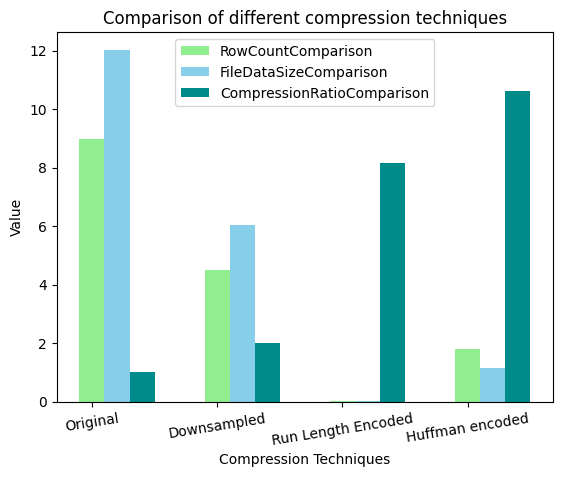

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt


# read the real data CSV file to save the file size
real_data = pd.read_csv('/content/rpmreading.csv')

# read the downsampled data CSV file to save the file size
downsampled_data = pd.read_csv('/content/downsampled_data.csv')

# read the downsampled data CSV file to save the file size
runlengthencoded_data = pd.read_csv('/content/runlengthencoded_data.csv')

# read the downsampled data CSV file to save the file size
huffmanencoded_data = pd.read_csv('/content/huffmanencoded_data.csv')

# get the number of rows and columns in each dataframe
rows1, cols1 = real_data.shape
rows2, cols2 = downsampled_data.shape
rows3, cols3 = runlengthencoded_data.shape
rows4, cols4 = huffmanencoded_data.shape

# calculate the total number of elements in each dataframe
original_rowcount = rows1 * cols1
downsampled_rowcount = rows2 * cols2
runlengthencodined_rowcount = rows3 * cols3
huffmanencoded_rowcount = rows4 * cols4
row_count = [original_rowcount/100000,downsampled_rowcount/100000,runlengthencodined_rowcount/100000,huffmanencoded_rowcount/100000]

realdatasize = os.path.getsize('/content/rpmreading.csv')
downsampleddatasize = os.path.getsize('/content/downsampled_data.csv')
runlengthencodeddatasize = os.path.getsize('/content/runlengthencoded_data.csv')
huffmanencodeddatasize = os.path.getsize('/content/huffmanencoded_data.csv')
data_size = [realdatasize/1000000,downsampleddatasize/1000000,runlengthencodined_rowcount/1000000,huffmanencodeddatasize/1000000]

realdatacompressionratio = 1
downsampleddatacompressionratio = realdatasize/downsampleddatasize
runlengthencodedcompressionratio = realdatasize/runlengthencodeddatasize
huffmanencodedcompressionratio = realdatasize/huffmanencodeddatasize
compression_ratio = [realdatacompressionratio,downsampleddatacompressionratio,runlengthencodedcompressionratio,huffmanencodedcompressionratio]

Compression = ['Original','Downsampled', 'Run Length Encoded', 'Huffman encoded']


y_axis=np.arange(len(Compression))
plt.bar(y_axis + 0, row_count,width=0.2, color = 'lightgreen' , label='RowCountComparison')
plt.bar(y_axis + 0.2,data_size, width=0.2,color = 'skyblue',label = 'FileDataSizeComparison')
plt.bar(y_axis + 0.4, compression_ratio,width=0.2, color = 'darkcyan' , label='CompressionRatioComparison')

plt.xticks(y_axis, Compression, rotation=9)
plt.legend(('RowCountComparison','FileDataSizeComparison', 'CompressionRatioComparison'))
plt.ylabel('Value')
plt.xlabel('Compression Techniques')
plt.title("Comparison of different compression techniques")
plt.show()



In [ ]:
import csv

def run_length_decoding(input_file_path, output_file_path):
    with open(input_file_path, newline='') as input_file:
        with open(output_file_path, 'w', newline='') as output_file:
            reader = csv.reader(input_file)
            writer = csv.writer(output_file)
            for row in reader:
                decompressed_row = []
                for value in row:
                    if ':' in value:
                        value_parts = value.split(':')
                        count = int(value_parts[0])
                        repeated_value = value_parts[1]
                        decompressed_row += [repeated_value] * count
                    else:
                        decompressed_row.append(value)
                writer.writerow(decompressed_row)
run_length_decoding('runlengthencoded_data.csv', 'runlengthdecoded_data.csv')

In [ ]:
import csv

def compare_csv_files(file1_path, file2_path):
    # Read in the contents of both CSV files
    with open(file1_path, newline='') as file1, open(file2_path, newline='') as file2:
        file1_reader = csv.reader(file1)
        file2_reader = csv.reader(file2)

        # Step 2: Compare the two CSV files row by row
        rows_match = True
        row_idx = 0
        while rows_match:
            file1_row = next(file1_reader, None)
            file2_row = next(file2_reader, None)

            # If we have reached the end of one or both files, stop comparing
            if file1_row is None or file2_row is None:
                break

            # If the rows don't match, print a message and stop comparing
            if file1_row != file2_row:
                print("The two CSV files differ at row", row_idx, ":")
                print(file1_row)
                print(file2_row)
                rows_match = False

            row_idx += 1

        # If the files have a different number of rows, print a message
        if rows_match is True and next(file1_reader, None) is not None:
            print("The two CSV files have a different number of rows:")
            print(file1_path, "has more rows")
        elif rows_match is True and next(file2_reader, None) is not None:
            print("The two CSV files have a different number of rows:")
            print(file2_path, "has more rows")
        else:
            print("The two CSV files have the same rows and values.")


compare_csv_files('runlengthdecoded_data.csv', 'rpmreading.csv')


The two CSV files differ at row 0 :
['nodeid', 'source', 'encoded_values']
['timestamp', 'nodeid', 'source', 'fqdd', 'value']
The two CSV files have the same rows and values.
